# Create Heterogeneous Graph

https://pytorch-geometric.readthedocs.io/en/latest/tutorial/heterogeneous.html

In [2]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data/metapath2vec', preprocess='metapath2vec')
print(len(dataset))
data = dataset[0]

Processing...
Done!


1


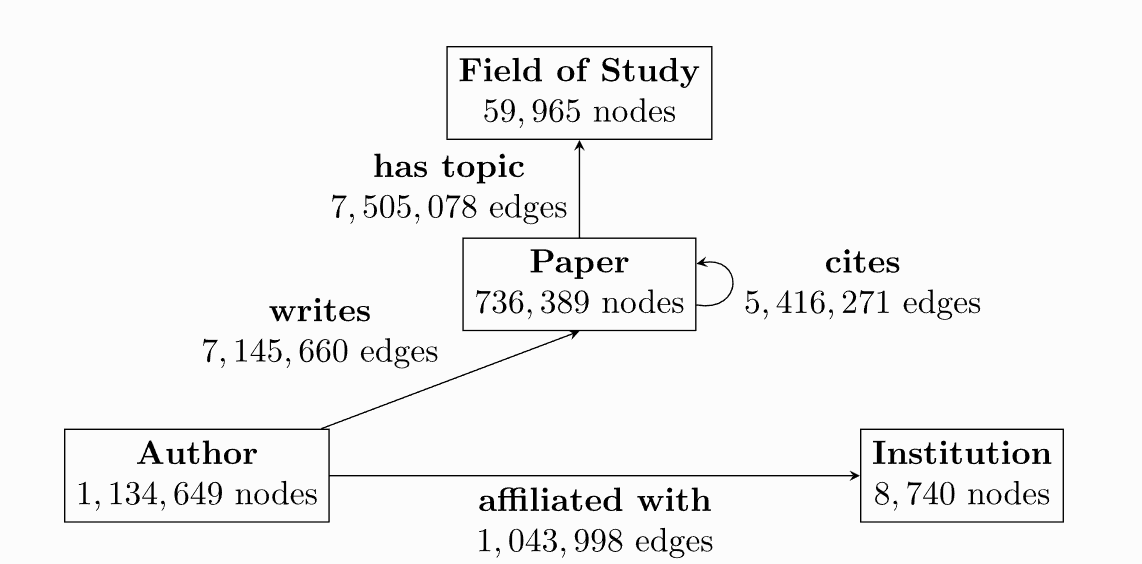

In [4]:
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389],
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

input feature として TransE の output を使ってもいいのかな。

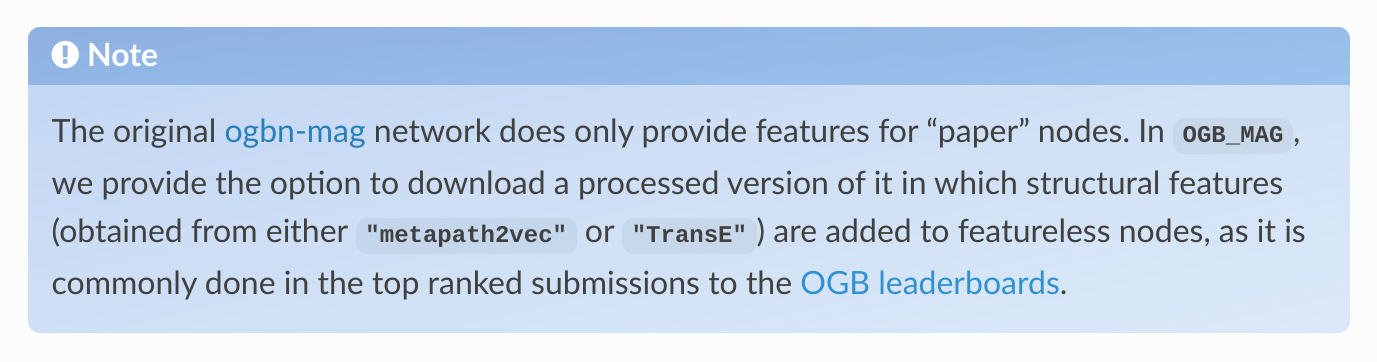

In [6]:
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_undirected())

False
False
False


`to_homogeneous()` method を使用すれば homogeneous graph もできる

In [7]:
homogeneous_data = data.to_homogeneous()
print(homogeneous_data)

Data(edge_index=[2, 21111007], x=[1939743, 128], year=[1939743], y=[1939743], train_mask=[1939743], val_mask=[1939743], test_mask=[1939743], node_type=[1939743], edge_type=[21111007])


## Heterogeneous Graph Transformations

In [20]:
import torch_geometric.transforms as T

data = T.ToUndirected()(data)
data = T.AddSelfLoops()(data)
data = T.NormalizeFeatures()(data)

## Automatically Converting GNN Models

In [25]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [26]:
dataset = OGB_MAG(root='./data/metapath2vec', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

In [28]:
model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
display(model)

GNN(
  (conv1): SAGEConv((-1, -1), 64, aggr=mean)
  (conv2): SAGEConv((-1, -1), 349, aggr=mean)
)

In [30]:
print(data.metadata())

(['paper', 'author', 'institution', 'field_of_study'], [('author', 'affiliated_with', 'institution'), ('author', 'writes', 'paper'), ('paper', 'cites', 'paper'), ('paper', 'has_topic', 'field_of_study'), ('institution', 'rev_affiliated_with', 'author'), ('paper', 'rev_writes', 'author'), ('field_of_study', 'rev_has_topic', 'paper')])


In [29]:
model = to_hetero(model, data.metadata(), aggr='sum')
display(model)

GraphModule(
  (conv1): ModuleDict(
    (author__affiliated_with__institution): SAGEConv((-1, -1), 64, aggr=mean)
    (author__writes__paper): SAGEConv((-1, -1), 64, aggr=mean)
    (paper__cites__paper): SAGEConv((-1, -1), 64, aggr=mean)
    (paper__has_topic__field_of_study): SAGEConv((-1, -1), 64, aggr=mean)
    (institution__rev_affiliated_with__author): SAGEConv((-1, -1), 64, aggr=mean)
    (paper__rev_writes__author): SAGEConv((-1, -1), 64, aggr=mean)
    (field_of_study__rev_has_topic__paper): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (author__affiliated_with__institution): SAGEConv((-1, -1), 349, aggr=mean)
    (author__writes__paper): SAGEConv((-1, -1), 349, aggr=mean)
    (paper__cites__paper): SAGEConv((-1, -1), 349, aggr=mean)
    (paper__has_topic__field_of_study): SAGEConv((-1, -1), 349, aggr=mean)
    (institution__rev_affiliated_with__author): SAGEConv((-1, -1), 349, aggr=mean)
    (paper__rev_writes__author): SAGEConv((-1, -1), 349, aggr=mean)
   

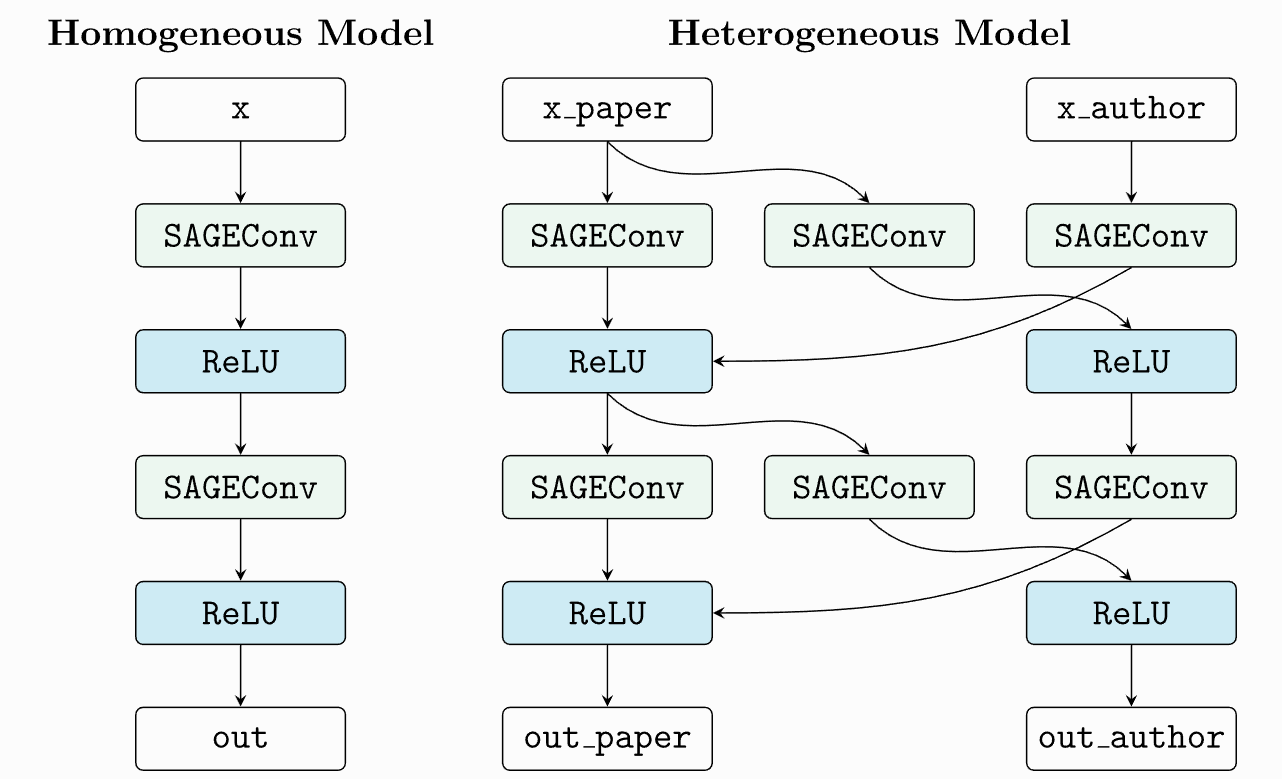